### By default
case 1:
- Amplitude 0.1, 30 sets, uniform distribution with (0.05, 0.1, 30), with noise amp of 0.01

case 2:
- Amplitude 0.1, 30 sets, Normal distribution with (1, 0.5, 30), with noise amp of 0.01

case 3:


References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

# Helper Functions

In [1]:
import numpy as np
currentAmp = 1
sets = 3
# noiseSD = 0.01
weights = np.random.uniform(0.05, 0.1, sets*2)
delayP1P2 = 0.1
delayP2P1 = 0.3

In [2]:
pip install neuron

     |████████████████████████████████| 15.0 MB 4.9 MB/s 


In [3]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    from hebb_test import ORN, MCELL, GCELL

In [4]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()



In [5]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [6]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [7]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [8]:
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
    f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
    f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
    plt2.show(f)

In [9]:
import math
def generate_L_weight_delta(first, second, A_minus=-0.011, A_plus=0.01):
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [10]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [11]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        self.stim = h.IClamp(self.P1.dend(0.5))
        # self.noise = np.random.normal(0, noiseSD.value, 100)
        # self.input = h.Vector(stairstep(0,currentAmp.value,10,100,self.noise))
        # self.tv = h.Vector([i for i in range(100)])
        # self.stim.delay = 10
        # self.stim.dur = 100
        # self.stim.amp = 0
        # self.input.play(self.stim._ref_amp, self.tv, True) 
        self.stim.delay = 10
        self.stim.dur = 100
        self.stim.amp = currentAmp
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        # print("mutual weight is ", weights[M])
        self.nc1.delay = delayP1P2 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = delayP2P1 #tP2P1
        self.nc2.threshold = self.th    

            

In [12]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
        #   print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

In [13]:
%matplotlib inline
def plotSpikes():
    color=['green','orange']
    label=['P1','P2']
    plt1.figure(figsize=(16,10))
    for j in range(len(L1.sets)):
    # for i,cell in enumerate(L1.sets[j].cells):
        plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
        plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
    plt1.xlabel('time(ms)')
    plt1.legend(label)
    plt1.show()

In [14]:
def countSpikes():
    sum1=0
    sum2=0
    list1=[]
    list2=[]
    for i in range(len(L1.sets)):
        list1.append(list(L1.sets[i].cells[0].spike_times))
        list2.append(list(L1.sets[i].cells[1].spike_times))
        sum1+=len(list1[-1])
        sum2+=len(list2[-1])
    return (sum1, sum2)

In [15]:
def learn(A_plus, A_minus):
    import sys, time
    tick = time.time()
    epochs = 30
    weight_data = []

    out = display(progress(0, epochs), display_id=True)

    for l in range(epochs):
        #print("iteration no is",l)
        out.update(progress(l, epochs))    
        # print("\nmutual learning")
        P1_axon_data = []
        P1_dend_data = []
        P2_axon_data = []
        P2_dend_data = []
        P1_spike_times = []
        P2_spike_times = []


        
        for i in range(len(L1.sets)):
            P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
            P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
            P1_spike_times.append(list(L1.sets[i].P1.spike_times))
            P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
            P2_spike_times.append(list(L1.sets[i].P2.spike_times))
            P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))

        t = h.Vector().record(h._ref_t)
        h.finitialize(-70* mV)
        h.continuerun(300*ms)

        # h.finitialize(-70 * mV)

        for i in range(len(L1.sets)):
            # 2-coupled STDP-based learning
            L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i], A_plus, A_minus)
            # logging
            # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
            L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i], A_plus, A_minus)
            
        # do a proper logging function
        weight_data.append(L1.sets[0].nc1.weight[0])
        # print(L1.sets[0].nc1.weight[0], L1.sets[0].nc2.weight[0])


        #Lateral Learning
        for i in range(len(L1.sets)-1):
            # print(i)
            # 2-coupled part
            L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1], A_plus, A_minus)
            L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i], A_plus, A_minus)
        
        # plotCell(L1.sets[i].P1, 'P1')
    out.update(progress(epochs, epochs))    
    tock = time.time()
    # print("The time it took to learn", tock-tick, "seconds")

# A_plus automation

In [16]:
p1_spikes = []
p2_spikes = []
for A_plus in np.arange(0.01, 0.21, 0.01).round(2):
    L1=LATERAL(sets,weights)
    print("The A_plus value is", A_plus)
    # print("Spikes Before Learning")
    # plotSpikes()
    learn(A_plus, -0.011)
    # print("Spikes After Learning")
    # plotSpikes()
    spikes = countSpikes()
    p1_spikes.append(spikes[0])
    p2_spikes.append(spikes[1])

The A_plus value is 0.01


The A_plus value is 0.02


The A_plus value is 0.03


The A_plus value is 0.04


The A_plus value is 0.05


The A_plus value is 0.06


The A_plus value is 0.07


The A_plus value is 0.08


The A_plus value is 0.09


The A_plus value is 0.1


The A_plus value is 0.11


The A_plus value is 0.12


The A_plus value is 0.13


The A_plus value is 0.14


The A_plus value is 0.15


The A_plus value is 0.16


The A_plus value is 0.17


The A_plus value is 0.18


The A_plus value is 0.19


The A_plus value is 0.2


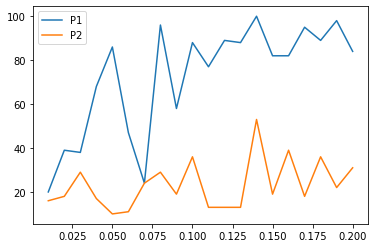

In [17]:
a_plus_val = [i for i in np.arange(0.01, 0.21, 0.01)]
legend=['P1', 'P2']
plt1.plot(a_plus_val, p1_spikes)
plt1.plot(a_plus_val, p2_spikes)
plt1.legend(legend)
plt1.show()

# A_minus automation

In [18]:
p1_spikes = []
p2_spikes = []
for A_minus in np.arange(-0.011, -0.22, -0.011).round(3):
    L1=LATERAL(sets,weights)
    print("The A_minus value is", A_minus)
    # print("Spikes Before Learning")
    # plotSpikes()
    learn(0.01, A_minus)
    # print("Spikes After Learning")
    # plotSpikes()
    spikes = countSpikes()
    p1_spikes.append(spikes[0])
    p2_spikes.append(spikes[1])

The A_minus value is -0.011


The A_minus value is -0.022


The A_minus value is -0.033


The A_minus value is -0.044


The A_minus value is -0.055


The A_minus value is -0.066


The A_minus value is -0.077


The A_minus value is -0.088


The A_minus value is -0.099


The A_minus value is -0.11


The A_minus value is -0.121


The A_minus value is -0.132


The A_minus value is -0.143


The A_minus value is -0.154


The A_minus value is -0.165


The A_minus value is -0.176


The A_minus value is -0.187


The A_minus value is -0.198


The A_minus value is -0.209


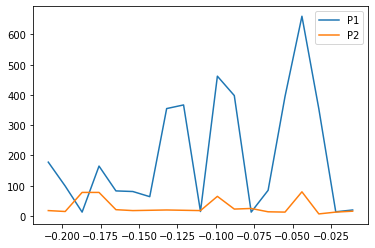

In [21]:
a_minus_val = np.arange(-0.011, -0.22, -0.011)
legend=['P1', 'P2']
plt1.plot(a_minus_val, p1_spikes)
plt1.plot(a_minus_val, p2_spikes)
plt1.legend(legend)

plt1.show()